## Demand Forecasting

### Requirements


1. Plan an Approach - what steps to do you plan to follow and why? This can be high-level, but please include 1-2 paragraphs explaining your approach to a potential non-Data Scientist stakeholder.
2. Forecast Generation - produce a 28 day forecast (i.e. for each item_id predict demand for days d_1942 thru d_1969)
3. Forecast Evaluation - how will you evaluate your forecast peformance (how will this differ before/after going live)?
4. Prepare for Discussion - your submission will be the starting point for a discussion, be prepared to talk about your solution, assumptions/tradeoffs, expect questions on how this exercise is analogous to data problems faced at Shipbob.
5. Submit Response - See bottom section (either create git repo or email files


### PLAN


My typical approach would be:

1. Understand data and how to access it. The aim is to forecast demand based on historical data.
2. Exploration analysis: get an idea of data distribution, is there seasonalities? special days? some aspects that calls our attention?
3. Try some simple model to  get a baseline. Then increasinlgy add complexity to the model and iterate until metrics are good enough. Typically
   - xgboost, arima family, etc.

Prepare data for training forecasting. Idea is to training and compare multiple models. 

Preprocessing ideas: 

    - Prepare lag features.
    - Rolling features: e.g. moving average
    - Prepare target, predict next day? next week? average demand for the future 28 days?

In [1]:
# # Additional packages installed, added to requirements 
# !pip install numpy=='1.26.4' 
# !pip install jupyter_black
# !pip install category_encoders

In [2]:
%run ./commons.ipynb

In [3]:
from utils import get_custom_calendar, get_input_data

import os
import numpy as np
import pandas as pd

pd.set_option("display.max_columns", None)
import matplotlib.pyplot as plt
import seaborn as sns
import datetime

from process import *

# 2013-09-25, 2016-05-22
# NOTE: Last date is not included in time interval

TRAIN_START = 1
TRAIN_END = 1941
TRAIN_START_DATE = datetime.datetime.strptime("2011-01-29", "%Y-%m-%d")
TRAIN_END_DATE = datetime.datetime.strptime("2016-05-23", "%Y-%m-%d")


TEST_START = 1942
TEST_END = 1969
TEST_START_DATE = datetime.datetime.strptime("2016-05-23", "%Y-%m-%d")
TEST_END_DATE = datetime.datetime.strptime("2016-06-20", "%Y-%m-%d")


train_cols = [f"d_{i}" for i in range(1, 1942)]
test_cols = [f"d_{i}" for i in range(1942, 1970)]
print(len(train_cols), train_cols[:5], train_cols[-5:])
print(len(test_cols), test_cols[:5], test_cols[-5:])


print("Train Days:", (TRAIN_END_DATE - TRAIN_START_DATE).days, len(train_cols))
print("Test Days:", (TEST_END_DATE - TEST_START_DATE).days, len(test_cols))

1941 ['d_1', 'd_2', 'd_3', 'd_4', 'd_5'] ['d_1937', 'd_1938', 'd_1939', 'd_1940', 'd_1941']
28 ['d_1942', 'd_1943', 'd_1944', 'd_1945', 'd_1946'] ['d_1965', 'd_1966', 'd_1967', 'd_1968', 'd_1969']
Train Days: 1941 1941
Test Days: 28 28


In [4]:
calendar = get_custom_calendar()
print(calendar.shape)
calendar

2025-01-25 08:47:01.415 | DEBUG    | process:load_calendar:30 - Begin Loading Calendar Data...


(1969, 7)


,d,date,wm_yr_wk,year,wknu,event_name_1,event_type_1
0,d_1,2011-01-29,11101,11,1,nan,nan
1,d_2,2011-01-30,11101,11,1,nan,nan
2,d_3,2011-01-31,11101,11,1,nan,nan
3,d_4,2011-02-01,11101,11,1,nan,nan
4,d_5,2011-02-02,11101,11,1,nan,nan
...,...,...,...,...,...,...,...
1964,d_1965,2016-06-15,11620,16,20,nan,nan
1965,d_1966,2016-06-16,11620,16,20,nan,nan
1966,d_1967,2016-06-17,11620,16,20,nan,nan
1967,d_1968,2016-06-18,11621,16,21,nan,nan


In [5]:
start_date = (TRAIN_END_DATE - datetime.timedelta(days=365 * 3)).strftime("%Y-%m-%d")

# train_selected_item = "FOODS_1_001"
# train_state = "CA"

train_selected_item = "FOODS_3_823"
train_state = "WI"


print(f"Start date used for training: {start_date}")
print(f"For item: {train_selected_item}")
print(f"For state: {train_state}")

Start date used for training: 2013-05-24
For item: FOODS_3_823
For state: WI


## 0. Prepare input data

In [6]:
# id_cols = ["id", "item_id", "dept_id", "cat_id", "store_id", "state_id"]
prices = load_prices(PATH_INPUT)
data = load_sales(PATH_INPUT, prices)

2025-01-25 08:47:01.473 | DEBUG    | process:load_prices:45 - Begin Loading Price Data...
2025-01-25 08:47:02.813 | DEBUG    | process:load_sales:62 - Begin Loading Sales Data...


In [7]:
# NOTES: custom functions ensures data is sorted
data = get_input_data(
    data=data,
    prices=prices,
    calendar=calendar,
    # start_date=start_date,
    state_id=train_state,
    item_id=train_selected_item,
    drop_columns=[],
)
print(data.shape)
data.dtypes
# CA, (7764, 13)

(5823, 13)


id                    category
item_id               category
dept_id               category
cat_id                category
store_id              category
state_id              category
d                       object
date            datetime64[ns]
wm_yr_wk                uint16
wknu                     int64
event_type_1          category
event_name_1          category
sales                  float32
dtype: object

In [8]:
data.head()

,id,item_id,dept_id,cat_id,store_id,state_id,d,date,wm_yr_wk,wknu,event_type_1,event_name_1,sales
0,FOODS_3_823_WI_1_evaluation,FOODS_3_823,FOODS_3,FOODS,WI_1,WI,d_1,2011-01-29,11101,1,nan,nan,0.0
1941,FOODS_3_823_WI_2_evaluation,FOODS_3_823,FOODS_3,FOODS,WI_2,WI,d_1,2011-01-29,11101,1,nan,nan,0.0
3882,FOODS_3_823_WI_3_evaluation,FOODS_3_823,FOODS_3,FOODS,WI_3,WI,d_1,2011-01-29,11101,1,nan,nan,0.0
1,FOODS_3_823_WI_1_evaluation,FOODS_3_823,FOODS_3,FOODS,WI_1,WI,d_2,2011-01-30,11101,1,nan,nan,0.0
1942,FOODS_3_823_WI_2_evaluation,FOODS_3_823,FOODS_3,FOODS,WI_2,WI,d_2,2011-01-30,11101,1,nan,nan,0.0


## 1. Feature Engineering

In [9]:
def prepare_datasets(data: pd.DataFrame) -> pd.DataFrame:
    df = data.copy()
    df = df.sort_values(by=["item_id", "store_id", "date"])
    selected_lags = list(range(7, 20))  # [7, 14, 28]
    average_windows = [7, 14, 28]

    for lag in selected_lags:
        df[f"sales_lag_{lag}"] = df.groupby(["item_id", "store_id"], observed=False)["sales"].shift(lag).fillna(0)

    for w in average_windows:
        df[f"rolling_mean_{lag}"] = df.groupby(["item_id", "store_id"], observed=False)["sales"].transform(
            lambda x: x.rolling(window=w).mean()
        )
        df[f"rolling_std_{lag}"] = df.groupby(["item_id", "store_id"], observed=False)["sales"].transform(
            lambda x: x.rolling(window=w).std()
        )

    # Other features:
    df["week_day"] = df["date"].dt.weekday
    df["day"] = df["date"].dt.day
    df["is_weekend"] = df["week_day"].isin([5, 6]).astype("int")

    return df


def classify_columns(df):
    ds = df.dtypes.reset_index().assign(Dtype=lambda x: x[0].astype(str))
    features_types = ds.groupby("Dtype")["index"].apply(list).to_dict()
    features_types["num"] = []
    for k, v in features_types.items():
        if "float" in k or "int" in k:
            features_types["num"] += v
    return features_types

In [10]:
print("Original data shape:", data.shape)

df = prepare_datasets(data)
df = df.dropna()

print("Clean data shape:", df.shape)
df.iloc[:10]

Original data shape: (5823, 13)
Clean data shape: (5742, 31)


,id,item_id,dept_id,cat_id,store_id,state_id,d,date,wm_yr_wk,wknu,event_type_1,event_name_1,sales,sales_lag_7,sales_lag_8,sales_lag_9,sales_lag_10,sales_lag_11,sales_lag_12,sales_lag_13,sales_lag_14,sales_lag_15,sales_lag_16,sales_lag_17,sales_lag_18,sales_lag_19,rolling_mean_19,rolling_std_19,week_day,day,is_weekend
27,FOODS_3_823_WI_1_evaluation,FOODS_3_823,FOODS_3,FOODS,WI_1,WI,d_28,2011-02-25,11104,4,nan,nan,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4,25,0
28,FOODS_3_823_WI_1_evaluation,FOODS_3_823,FOODS_3,FOODS,WI_1,WI,d_29,2011-02-26,11105,5,nan,nan,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5,26,1
29,FOODS_3_823_WI_1_evaluation,FOODS_3_823,FOODS_3,FOODS,WI_1,WI,d_30,2011-02-27,11105,5,nan,nan,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,6,27,1
30,FOODS_3_823_WI_1_evaluation,FOODS_3_823,FOODS_3,FOODS,WI_1,WI,d_31,2011-02-28,11105,5,nan,nan,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,28,0
31,FOODS_3_823_WI_1_evaluation,FOODS_3_823,FOODS_3,FOODS,WI_1,WI,d_32,2011-03-01,11105,5,nan,nan,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,1,0
32,FOODS_3_823_WI_1_evaluation,FOODS_3_823,FOODS_3,FOODS,WI_1,WI,d_33,2011-03-02,11105,5,nan,nan,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2,2,0
33,FOODS_3_823_WI_1_evaluation,FOODS_3_823,FOODS_3,FOODS,WI_1,WI,d_34,2011-03-03,11105,5,nan,nan,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3,3,0
34,FOODS_3_823_WI_1_evaluation,FOODS_3_823,FOODS_3,FOODS,WI_1,WI,d_35,2011-03-04,11105,5,nan,nan,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4,4,0
35,FOODS_3_823_WI_1_evaluation,FOODS_3_823,FOODS_3,FOODS,WI_1,WI,d_36,2011-03-05,11106,6,nan,nan,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5,5,1
36,FOODS_3_823_WI_1_evaluation,FOODS_3_823,FOODS_3,FOODS,WI_1,WI,d_37,2011-03-06,11106,6,nan,nan,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,6,6,1


In [11]:
idcols = ["id", "item_id", "dept_id", "cat_id", "date", "d", "wm_yr_wk"]
target = ["sales"]
features = [c for c in df.columns if c not in idcols + target]
features_types = classify_columns(df[features])

categorical_cols = features_types["category"]
numerical_cols = features_types["num"]

print(f"Categorical cols: {categorical_cols}")
print(f"Numerical cols: {numerical_cols}")

Categorical cols: ['store_id', 'state_id', 'event_type_1', 'event_name_1']
Numerical cols: ['sales_lag_7', 'sales_lag_8', 'sales_lag_9', 'sales_lag_10', 'sales_lag_11', 'sales_lag_12', 'sales_lag_13', 'sales_lag_14', 'sales_lag_15', 'sales_lag_16', 'sales_lag_17', 'sales_lag_18', 'sales_lag_19', 'rolling_mean_19', 'rolling_std_19', 'week_day', 'day', 'wknu', 'is_weekend']


In [12]:
def custom_train_test_split(X, y, test_size):
    """
    Perform train-test split keeping time series sorted
    """
    X_train = X.iloc[:-test_size]
    y_train = y.iloc[:-test_size]
    X_test = X.iloc[-test_size:]
    y_test = y.iloc[-test_size:]

    return X_train, X_test, y_train, y_test


X_train, X_test, y_train, y_test = custom_train_test_split(
    X=df.dropna().drop(columns=["sales"]), y=df.dropna()["sales"], test_size=int(0.3 * len(df))
)
print(X_train.shape, X_test.shape)

(4020, 30) (1722, 30)


In [13]:
X_test.head()

,id,item_id,dept_id,cat_id,store_id,state_id,d,date,wm_yr_wk,wknu,event_type_1,event_name_1,sales_lag_7,sales_lag_8,sales_lag_9,sales_lag_10,sales_lag_11,sales_lag_12,sales_lag_13,sales_lag_14,sales_lag_15,sales_lag_16,sales_lag_17,sales_lag_18,sales_lag_19,rolling_mean_19,rolling_std_19,week_day,day,is_weekend
4101,FOODS_3_823_WI_3_evaluation,FOODS_3_823,FOODS_3,FOODS,WI_3,WI,d_220,2011-09-05,11132,32,National,LaborDay,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,1.0,0.785714,1.197440,0,5,0
4102,FOODS_3_823_WI_3_evaluation,FOODS_3_823,FOODS_3,FOODS,WI_3,WI,d_221,2011-09-06,11132,32,nan,nan,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.714286,1.117442,1,6,0
4103,FOODS_3_823_WI_3_evaluation,FOODS_3_823,FOODS_3,FOODS,WI_3,WI,d_222,2011-09-07,11132,32,nan,nan,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,0.714286,1.117442,2,7,0
4104,FOODS_3_823_WI_3_evaluation,FOODS_3_823,FOODS_3,FOODS,WI_3,WI,d_223,2011-09-08,11132,32,nan,nan,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.678571,1.123934,3,8,0
4105,FOODS_3_823_WI_3_evaluation,FOODS_3_823,FOODS_3,FOODS,WI_3,WI,d_224,2011-09-09,11132,32,nan,nan,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.714286,1.117442,4,9,0


## 2. Model Training


In [14]:
from typing import List
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from category_encoders import CatBoostEncoder
from xgboost import XGBRegressor
from sklearn.ensemble import RandomForestRegressor


def create_pipeline(numerical_columns: List[str], categorical_columns: List[str]):
    # Preprocessing:
    # Handle missing categorical values
    # Use CatBoostEncoder
    categorical_preprocessor = Pipeline(
        steps=[
            ("imputer", SimpleImputer(strategy="most_frequent")),
            ("encoder", CatBoostEncoder()),
        ]
    )

    numerical_preprocessor = Pipeline(
        steps=[
            ("imputer", SimpleImputer(strategy="mean")),
        ]
    )

    # Combine preprocessors in a ColumnTransformer
    preprocessor = ColumnTransformer(
        transformers=[
            ("num", numerical_preprocessor, numerical_columns),
            ("cat", categorical_preprocessor, categorical_columns),
        ]
    )

    rf_reg_params = {
        "bootstrap": True,
        "ccp_alpha": 0.0,
        "criterion": "squared_error",
        "max_depth": None,
        "max_features": 1.0,
        "max_leaf_nodes": None,
        "max_samples": None,
        "min_impurity_decrease": 0.0,
        "min_samples_leaf": 1,
        "min_samples_split": 2,
        "min_weight_fraction_leaf": 0.0,
        "monotonic_cst": None,
        "n_estimators": 150,
        "n_jobs": None,
        "oob_score": False,
        "random_state": 42,
        "verbose": 0,
        "warm_start": False,
    }

    pipeline = Pipeline(
        steps=[
            ("preprocessor", preprocessor),
            # ("to_numpy", FunctionTransformer(lambda x: x.values)),  # Explicitly convert to NumPy array
            ("regressor", RandomForestRegressor(**rf_reg_params)),
        ]
    )

    return pipeline

In [15]:
pipe = create_pipeline(
    categorical_columns=categorical_cols,
    numerical_columns=numerical_cols,
)
pipe

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer())]),
                                                  ['sales_lag_7', 'sales_lag_8',
                                                   'sales_lag_9',
                                                   'sales_lag_10',
                                                   'sales_lag_11',
                                                   'sales_lag_12',
                                                   'sales_lag_13',
                                                   'sales_lag_14',
                                                   'sales_lag_15',
                                                   'sales_lag_16',
                                                   'sales_lag_17',
                                                   'sales_lag_18',
                                                   'sales_lag_19',
                                                   'rolling_mean_19',
                                                   'rolling_std_19', 'week_day',
                                                   'day', 'wknu',
                                                   'is_weekend']),
                                                 ('cat',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('encoder',
                                                                   CatBoostEncoder())]),
                                                  ['store_id', 'state_id',
                                                   'event_type_1',
                                                   'event_name_1'])])),
                ('regressor',
                 RandomForestRegressor(n_estimators=150, random_state=42))])

In [16]:
model = pipe.fit(X_train, y_train)

### 2.1 Feature Importances

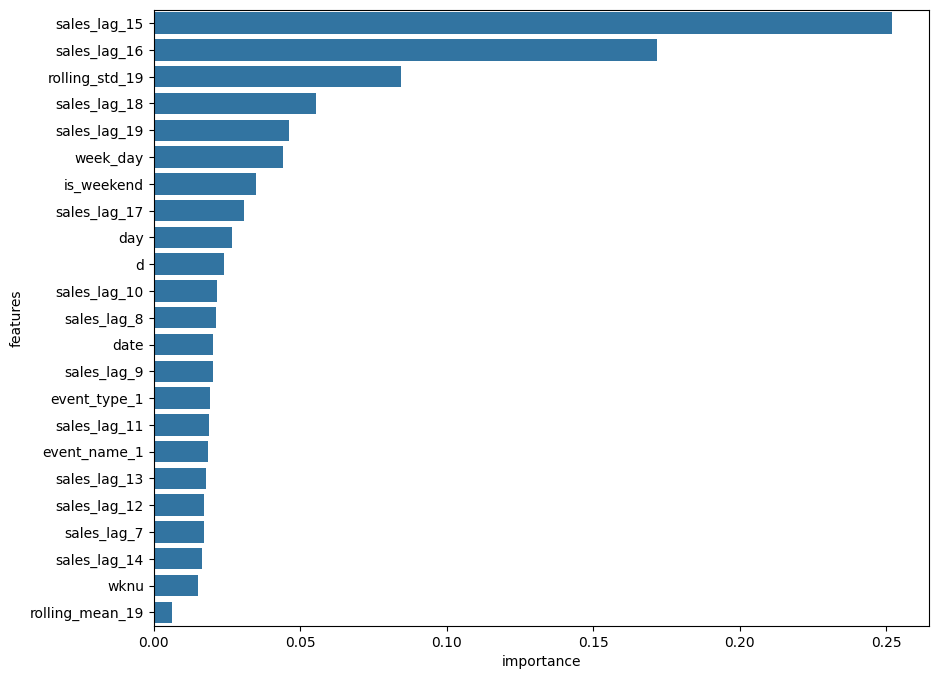

In [17]:
fimp = pd.DataFrame(
    dict(
        features=[c for c in X_train.columns if c not in id_cols + ["wm_yr_wk"]],
        importance=model.steps[1][1].feature_importances_,
    )
).sort_values("importance", ascending=False)

fig, ax = plt.subplots(figsize=(10, 8))
_ = sns.barplot(fimp, y="features", x="importance", ax=ax, orient="h")

## 3. Model Assesment

In [18]:
x_transform = model.steps[0][1].transform(X_train)
# just checking
# todo: we have to drop all those columns with std=0
pd.DataFrame(x_transform).describe().round(2)

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22
count,4020.00,4020.00,4020.00,4020.00,4020.00,4020.00,4020.00,4020.00,4020.00,4020.00,4020.00,4020.00,4020.00,4020.00,4020.00,4020.0,4020.00,4020.00,4020.00,4020.00,4020.00,4020.00,4020.00
mean,0.56,0.56,0.56,0.56,0.56,0.56,0.56,0.56,0.56,0.56,0.56,0.56,0.56,0.56,0.63,3.0,15.71,25.50,0.29,0.56,0.56,0.56,0.56
std,1.15,1.15,1.15,1.15,1.15,1.15,1.15,1.15,1.15,1.15,1.15,1.15,1.15,0.71,0.67,2.0,8.81,14.95,0.45,0.32,0.00,0.03,0.09
min,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.0,1.00,1.00,0.00,0.48,0.56,0.43,0.05
25%,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.0,8.00,12.00,0.00,0.48,0.56,0.57,0.57
50%,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.43,0.69,3.0,16.00,25.00,0.00,0.50,0.56,0.57,0.57
75%,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,0.93,1.06,5.0,23.00,38.00,1.00,0.50,0.56,0.57,0.57
max,12.00,12.00,12.00,12.00,12.00,12.00,12.00,12.00,12.00,12.00,12.00,12.00,12.00,4.82,3.33,6.0,31.00,53.00,1.00,2.00,0.56,0.57,1.51


In [19]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score, root_mean_squared_error


def compute_metrics(actual, forecast):
    # Compute Metrics
    metrics = dict(
        mae=mean_absolute_error(actual, forecast),
        rmse=root_mean_squared_error(actual, forecast),
        mape=np.mean(np.abs((actual - forecast) / actual)) * 100,
        smape=100 / len(actual) * np.sum(2 * np.abs(actual - forecast) / (np.abs(actual) + np.abs(forecast))),
        r2=r2_score(actual, forecast),
    )
    print(f"Mean Absolute Error (MAE): {metrics['mae']:2.2f}")
    print(f"Root Mean Squared Error (RMSE): {metrics['rmse']:2.2f}")
    print(f"Mean Absolute Percentage Error (MAPE): {metrics['mape']}%")
    print(f"Symmetric Mean Absolute Percentage Error (sMAPE): {metrics['smape']:2.2f}%")
    print(f"R-squared: {metrics['r2']:2.2f}")
    return metrics


def plot_actual_vs_pred(actual, forecast):
    ax = sns.lineplot(x=actual, y=forecast)
    ax.plot([0, max(actual)], [0, max(actual)], c="r", ls=":")
    ax.grid(axis="y")

Mean Absolute Error (MAE): 0.38
Root Mean Squared Error (RMSE): 0.69
Mean Absolute Percentage Error (MAPE): inf%
Symmetric Mean Absolute Percentage Error (sMAPE): 68.63%
R-squared: 0.63


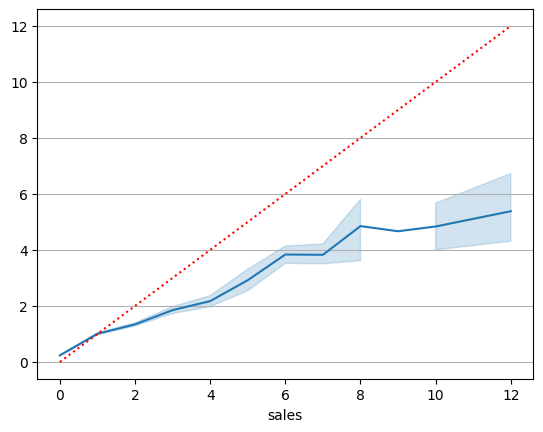

In [20]:
# Train scores
y_pred = model.predict(X_train)

plot_actual_vs_pred(y_train, y_pred)
metrics = compute_metrics(y_train, y_pred)

**NOTES**

- Predictions are always below the actual values. This is expected due to characteristics of xgboost (tree based model).
- Some improvements can be obtained if we optimized the metaparameters of the xgboost.

Mean Absolute Error (MAE): 0.41
Root Mean Squared Error (RMSE): 0.71
Mean Absolute Percentage Error (MAPE): inf%
Symmetric Mean Absolute Percentage Error (sMAPE): 82.97%
R-squared: 0.12


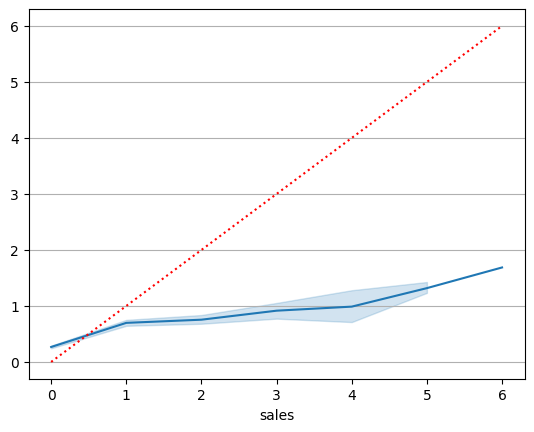

In [21]:
# Test Metrics
y_test_pred = model.predict(X_test)
plot_actual_vs_pred(y_test, y_test_pred)
metrics = compute_metrics(y_test, y_test_pred)

**NOTES**
- Clearly the model is overfitted. Results are much worst in the test scenario.

- First approach: Want to predict for 1 item in 1 store 

## 4. Create Submission

In [22]:
data_path = "data/m5/datasets"
data_dict = {
    "TRAINING_VAL_DATA": "sales_train_evaluation.csv",
    "TRAINING_DATA": "sales_train_validation.csv",
    "VALIDATION_DATA": "sales_test_validation.csv",
    "TEST_DATA": "sales_test_evaluation.csv",
    "CALENDAR": "calendar.csv",
    "PRICE_DATA": "sell_prices.csv",
}

# Item selection:
selected_item = "FOODS_3_823"
state = "WI"

In [23]:
file = os.path.join(data_path, data_dict["TEST_DATA"])
data_test = load_sales(
    PATH_INPUT,
    prices,
    data_dict["TEST_DATA"],
)
print(file)
print(data_test.shape)

data_test = get_input_data(
    data=data_test,
    prices=prices,
    calendar=calendar,
    state_id=state,
    item_id=selected_item,
    drop_columns=[],
)

data_test

2025-01-25 08:47:16.139 | DEBUG    | process:load_sales:62 - Begin Loading Sales Data...


data/m5/datasets/sales_test_evaluation.csv
(30490, 34)


,id,item_id,dept_id,cat_id,store_id,state_id,d,date,wm_yr_wk,wknu,event_type_1,event_name_1,sales
0,FOODS_3_823_WI_1_evaluation,FOODS_3_823,FOODS_3,FOODS,WI_1,WI,d_1942,2016-05-23,11617,17,nan,nan,1
28,FOODS_3_823_WI_2_evaluation,FOODS_3_823,FOODS_3,FOODS,WI_2,WI,d_1942,2016-05-23,11617,17,nan,nan,0
56,FOODS_3_823_WI_3_evaluation,FOODS_3_823,FOODS_3,FOODS,WI_3,WI,d_1942,2016-05-23,11617,17,nan,nan,0
1,FOODS_3_823_WI_1_evaluation,FOODS_3_823,FOODS_3,FOODS,WI_1,WI,d_1943,2016-05-24,11617,17,nan,nan,1
29,FOODS_3_823_WI_2_evaluation,FOODS_3_823,FOODS_3,FOODS,WI_2,WI,d_1943,2016-05-24,11617,17,nan,nan,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
54,FOODS_3_823_WI_2_evaluation,FOODS_3_823,FOODS_3,FOODS,WI_2,WI,d_1968,2016-06-18,11621,21,nan,nan,2
82,FOODS_3_823_WI_3_evaluation,FOODS_3_823,FOODS_3,FOODS,WI_3,WI,d_1968,2016-06-18,11621,21,nan,nan,1
27,FOODS_3_823_WI_1_evaluation,FOODS_3_823,FOODS_3,FOODS,WI_1,WI,d_1969,2016-06-19,11621,21,Sporting,NBAFinalsEnd,0
55,FOODS_3_823_WI_2_evaluation,FOODS_3_823,FOODS_3,FOODS,WI_2,WI,d_1969,2016-06-19,11621,21,Sporting,NBAFinalsEnd,1


In [24]:
# Checking selection of item:
# Test data is for WI state only! Interesting...
data_test[data_test["state_id"] == "WI"]

,id,item_id,dept_id,cat_id,store_id,state_id,d,date,wm_yr_wk,wknu,event_type_1,event_name_1,sales
0,FOODS_3_823_WI_1_evaluation,FOODS_3_823,FOODS_3,FOODS,WI_1,WI,d_1942,2016-05-23,11617,17,nan,nan,1
28,FOODS_3_823_WI_2_evaluation,FOODS_3_823,FOODS_3,FOODS,WI_2,WI,d_1942,2016-05-23,11617,17,nan,nan,0
56,FOODS_3_823_WI_3_evaluation,FOODS_3_823,FOODS_3,FOODS,WI_3,WI,d_1942,2016-05-23,11617,17,nan,nan,0
1,FOODS_3_823_WI_1_evaluation,FOODS_3_823,FOODS_3,FOODS,WI_1,WI,d_1943,2016-05-24,11617,17,nan,nan,1
29,FOODS_3_823_WI_2_evaluation,FOODS_3_823,FOODS_3,FOODS,WI_2,WI,d_1943,2016-05-24,11617,17,nan,nan,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
54,FOODS_3_823_WI_2_evaluation,FOODS_3_823,FOODS_3,FOODS,WI_2,WI,d_1968,2016-06-18,11621,21,nan,nan,2
82,FOODS_3_823_WI_3_evaluation,FOODS_3_823,FOODS_3,FOODS,WI_3,WI,d_1968,2016-06-18,11621,21,nan,nan,1
27,FOODS_3_823_WI_1_evaluation,FOODS_3_823,FOODS_3,FOODS,WI_1,WI,d_1969,2016-06-19,11621,21,Sporting,NBAFinalsEnd,0
55,FOODS_3_823_WI_2_evaluation,FOODS_3_823,FOODS_3,FOODS,WI_2,WI,d_1969,2016-06-19,11621,21,Sporting,NBAFinalsEnd,1


In [25]:
df_val = prepare_datasets(data_test)
print(df_val.shape)
df_val.head()

(84, 31)


,id,item_id,dept_id,cat_id,store_id,state_id,d,date,wm_yr_wk,wknu,event_type_1,event_name_1,sales,sales_lag_7,sales_lag_8,sales_lag_9,sales_lag_10,sales_lag_11,sales_lag_12,sales_lag_13,sales_lag_14,sales_lag_15,sales_lag_16,sales_lag_17,sales_lag_18,sales_lag_19,rolling_mean_19,rolling_std_19,week_day,day,is_weekend
0,FOODS_3_823_WI_1_evaluation,FOODS_3_823,FOODS_3,FOODS,WI_1,WI,d_1942,2016-05-23,11617,17,nan,nan,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,0,23,0
1,FOODS_3_823_WI_1_evaluation,FOODS_3_823,FOODS_3,FOODS,WI_1,WI,d_1943,2016-05-24,11617,17,nan,nan,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,1,24,0
2,FOODS_3_823_WI_1_evaluation,FOODS_3_823,FOODS_3,FOODS,WI_1,WI,d_1944,2016-05-25,11617,17,nan,nan,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,2,25,0
3,FOODS_3_823_WI_1_evaluation,FOODS_3_823,FOODS_3,FOODS,WI_1,WI,d_1945,2016-05-26,11617,17,nan,nan,2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,3,26,0
4,FOODS_3_823_WI_1_evaluation,FOODS_3_823,FOODS_3,FOODS,WI_1,WI,d_1946,2016-05-27,11617,17,nan,nan,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,4,27,0


In [26]:
df_val = reduce_mem_usage(df_val)

2025-01-25 08:47:16.887 | INFO     | process:reduce_mem_usage:166 - Mem. usage decreased to  1.33 Mb (0.7% reduction)


Mean Absolute Error (MAE): 0.66
Root Mean Squared Error (RMSE): 0.85
Mean Absolute Percentage Error (MAPE): inf%
Symmetric Mean Absolute Percentage Error (sMAPE): 158.63%
R-squared: -0.17


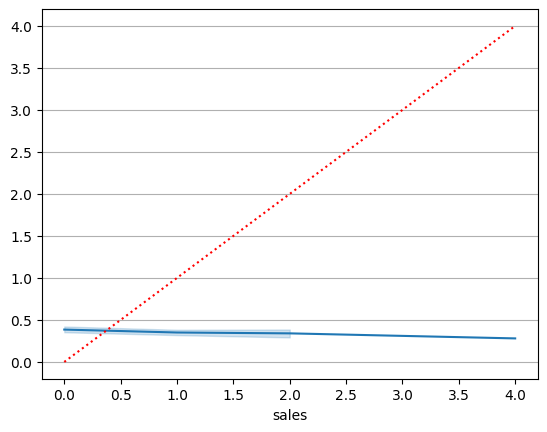

In [27]:
y_val_pred = model.predict(df_val)
y_val = df_val["sales"]
plot_actual_vs_pred(y_val, y_val_pred)
_ = compute_metrics(y_val, y_val_pred)

In [36]:
selected_ids = [c for c in id_cols if c not in ["id"]]
submission = df_val[selected_ids + ["d"]].copy()
submission["sales_predicted"] = model.predict(df_val)
submission = (
    submission.pivot_table(index=selected_ids, columns="d", values="sales_predicted", observed=True)
    .round(0)
    .reset_index()
)
submission.columns.name = None
submission

,item_id,dept_id,cat_id,store_id,state_id,d_1942,d_1943,d_1944,d_1945,d_1946,d_1947,d_1948,d_1949,d_1950,d_1951,d_1952,d_1953,d_1954,d_1955,d_1956,d_1957,d_1958,d_1959,d_1960,d_1961,d_1962,d_1963,d_1964,d_1965,d_1966,d_1967,d_1968,d_1969
0,FOODS_3_823,FOODS_3,FOODS,WI_1,WI,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
1,FOODS_3_823,FOODS_3,FOODS,WI_2,WI,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,FOODS_3_823,FOODS_3,FOODS,WI_3,WI,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0



## 5. How To Continue... 

There are still many points to explore and improve:


1. Optimization of Hyperparameters: Implement GridSearch to tune the metaparameters of the Random Forest model.
2. Extend to Weekly/Monthly Demand Prediction: Adapt the framework to predict expected demand on a weekly or monthly basis.
3. Predict Demand for Multiple Items: Explore alternatives for predicting sales across all items, either by parallelizing the existing framework or retraining the model with all items for a given store or state.
5. Alternative Models: Explore the use of ARIMA for time series forecasting, as well as conduct analysis of seasonality and trends.
